# Tree-based models - Learning notebook

## Imports

In [1]:
from math import log2

import pandas as pd
import numpy as np

from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from IPython.display import Image

from utils.utils import *

# Table of Contents

1. [Decision trees](#decision-trees)
2. [Tree-based ensembles](#tree-based-ensembles)
3. [Bagging with random forests](#bagging-with-random-forests)
4. [Boosting with gradient boosting](#boosting-with-gradient-boosting)

# Decision trees

Knowledge-based systems represent knowledge explicitly, as a set of rules, rather than being implicit in algorithms. 

Imagine we want to decide whether to go hicking based on the weather, then our acquired knowledge can be represented as:

<img src="assets/simple-decision-tree.png" alt="simple-decision-tree" style="width: 600px;"/>

*Fig. 1: A simple decision-tree used for classification (Quinlan, 1986).*

This particular structure, a **decision-tree**, displays a flow of conditional statements (i.e., `if Condition then Outcome`) where:

* Each **node** represents a test on a feature
* Each **branch** represents the outcome of the test
* Each **leaf** represents the outcome or decision.

The paths from root to leaf represent the rules, e.g., `if Outlook is Sunny and Humidity is Normal then Go Hicking`.

Pioneering knowledge-based expert systems codified rules coming from domain specialists, at the rate of a few rules per man day.

But complex tasks require creating and maintaining thousands of such rules, turning the "interview approach" into a bottleneck.

## Learning rule-sets as decision trees

This perception stimulated the investigation of general-purpose machine learning methods to build knowledge-based sytems.

The resulting systems address the underlying task of learning simple rules, inducing decision trees from examples.

Typically, a decision tree is developed from the top-down (known as top-down induction), guided by frequency information.

From there, there are a number of tree algorithms, including:
* **Iterative Dichotomiser 3 (ID3)**, for classification using categorical features
* **C4.5**, extends ID3 to support non-categorical features
* **Classification and Regression Trees (CART)**, generalizes C4.5 to support regression.

We follow ID3 ([Quinlan, 1986][1]), for binary classification using categorical features with a small set of possible values (i.e., low cardinality).

[1]: http://hunch.net/~coms-4771/quinlan.pdf "Quinlan, J. 1986. Induction of Decision Trees. Machine Learning 1: 81-106."

In [2]:
data = make_data()

### Algorithm overview

Take an arbitrary training set $C = \{x_i, y_i\}_{i=1}^m$, a collection of labeled observations, so as $y_i \in \{L_1, \dots, L_v\}$.

The features vector is represented as $x_i = \{x_i^{(1)}, \dots, x_i^{(n)}\}$, where $x_i^{(j)}$ is the value of the $j$-th feature for the $i$-th observation.

In ID3, $x_i^{(j)}$ can take on one of a fixed number of possible values $x_i^{(j)} \in \{A_1^{(j)}, \dots, A_w^{(j)}\}$.

$$X = \begin{bmatrix}
  x_1^{(1)} & x_1^{(2)} & \dots & x_1^{(n)} \\
  x_2^{(1)} & x_2^{(2)} & \dots & x_2^{(n)} \\
  \dots     & \dots     & \dots & \dots     \\
  x_m^{(1)} & x_m^{(2)} & \dots & x_m^{(n)}
 \end{bmatrix}$$

In [3]:
X, y = separate_target_variable(data)

X

,Outlook,Temperature,Humidity,Windy
0,sunny,hot,high,false
1,sunny,hot,high,true
2,overcast,hot,high,false
3,rain,mild,high,false
4,rain,cool,normal,false
5,rain,cool,normal,false
6,overcast,cool,normal,false
7,sunny,mild,high,false
8,sunny,cool,normal,false
9,rain,mild,normal,false


This is a binary classification problem, where $y_i \in \{0, 1\}.$

$$y = \begin{bmatrix}
  y_1   \\
  y_2   \\
  \dots \\
  y_3 
 \end{bmatrix}$$

In [4]:
y

0     0
1     0
2     1
3     1
4     1
5     0
6     1
7     0
8     1
9     1
10    1
11    1
12    1
13    0
Name: Class, dtype: int64

Now, imagine a test, $T$, on $x_i$, with possible outcomes $O_1, O_2, \dots, O_w$. 

It can be a condition on the features, for example.

$T$ produces a partition $\{C_1, C_2, \dots, C_w\}$ of $C$, where $C_k$ contains those observations having outcome $O_k$.

<img src="assets/test-partitioning.png" alt="test_partitioning" style="width: 600px;"/>

*Fig. 2: Partitioning of the objects in $C$ with a test $T$ (Quinlan, 1986).*

If each subset $C_k$ is replaced by a new decision-tree, the result would be a decision-tree for all of $C$.

Therefore, we recursively repeat the process in each partition until we get homogenous (i.e., single-class) leafs:

```
ID3 (Data, Target, Attributes)
    If all examples are positive, Return the single-node tree Root, with label = 1.
    If all examples are negative, Return the single-node tree Root, with label = 0.
    Otherwise Begin
        A <- Pick the Attribute that best classifies examples.
        Decision tree for Root = A.
        For each possible value, v_i, of A,
            Add a new tree branch, corresponding to the test A = v_i.
            Let Data(v_i) be the subset of examples that have the value v_i for A.
            Below this new branch add the subtree ID3 (Data(v_i), Target, Attributes – {A}).
    End
    Return Root
```

The question being, what exactly do we mean by "attribute that best classifies examples"? That with the most information.

## Attribute selection

**Information** is defined as (absense of) [entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory)): the greater the homogeneity of a set, the lower the entropy.

Take $p$ as the probability of the positive class, i.e., the proportion of positive cases in the set.

In binary classification (it can be extended to support multi-class settings), the entropy is given by:

$$I(p) = - p \log_2 p - (1 - p) \log_2 (1-p)$$

It ranges between 0 ($p=1$ or $p=0$, i.e., low entropy and high purity) and 1 ($p=\frac{1}{2}$, i.e., high entropy and low purity).

In [1]:
def entropy(p):
    if 0 < p < 1:
        return -p * log2(p) - (1 - p) * log2(1 - p)
    else:
        return 0

In [4]:
entropy(0.6)

NameError: name 'log2' is not defined

We compute the entropy for the entire data set.

In [35]:
data

,Outlook,Temperature,Humidity,Windy,Class
0,sunny,hot,high,false,0
1,sunny,hot,high,true,0
2,overcast,hot,high,false,1
3,rain,mild,high,false,1
4,rain,cool,normal,false,1
5,rain,cool,normal,false,0
6,overcast,cool,normal,false,1
7,sunny,mild,high,false,0
8,sunny,cool,normal,false,1
9,rain,mild,normal,false,1


In [36]:
def compute_probability(data):
    n = data.shape[0]
    f = (data['Class'] == 1).sum()

    return f / n


p = compute_probability(data)

In [37]:
entropy(p)

0.9402859586706311

In [6]:
def gini(p):
    # YOUR CODE HERE
    gini = 1 - p**2 - (1 - p)**2
    return gini


Above, we have the (fairly high) entropy for the entire data set. Out of curiosity, entropy is measured in bits.

This means that substancial proportions of the data set belong to each of the classes, as confirmed by the value of $p$.

In [8]:
p

0.6428571428571429

As we aim to form homogeneous groupings, we select the test $T$ with the most information.

A test is restricted to branching on an attribute $A$ with values $\{A_1, A_2, \dots, A_v\}$, thus partitioning $C$ into $\{C_1, C_2, \dots, C_v\}$. 

The expected information of the test is obtained as a weighted average of the entropy of the resulting groupings:

$$E(A) = \sum_{i=1}^v \frac{\|C_i\|}{\|C\|}I(p_i)$$

In short, and as expected, we are measuring an attribute's ability to generate homogeneous groupings.

In [9]:
def mean_entropy(data, attribute):
    c_norm = X.shape[0]
    information = 0
    values = data[attribute].unique()
    for value in values:
        group = data[data[attribute] == value]
        
        p_norm = group.shape[0]
        
        w = p_norm / c_norm
        
        p = compute_probability(group)
        e = entropy(p)
    
        information += w * e
    
    return information


mean_entropy(data, 'Outlook')

0.6935361388961918

Given this result, the feature `Outlook` yields branches that have a much lower entropy than the entire data set.

The **information gain** of branching on an attribute $A$ is, perhaps unsurprisingly, measured as:

$$IG(A) = I(p) - E(A)$$

Let's compute it.

In [10]:
def information_gain(data, attribute):
    p = compute_probability(data)
    i = entropy(p)
    
    e = mean_entropy(data, attribute)
    
    return i - e


information_gain(data, 'Outlook')

0.24674981977443933

To generate the simplest possible tree, it is sensible to branch on the attribute with more information.

In [11]:
def examine_candidate_attributes(data, attributes):
    return {attribute:information_gain(data, attribute) for attribute in attributes}


attributes = [c for c in data.columns if c is not 'Class']
examine_candidate_attributes(data, attributes)

{'Outlook': 0.24674981977443933,
 'Temperature': 0.02922256565895487,
 'Humidity': 0.15183550136234159,
 'Windy': 0.02507817350585062}

So, we would start by branching on the values of the `Outlook` attribute.

In [12]:
outlook_values = data['Outlook'].unique()
outlook_values

array(['sunny', 'overcast', 'rain'], dtype=object)

In [13]:
for i, value in enumerate(outlook_values):
    partition = data[data['Outlook'] == value]
    results = examine_candidate_attributes(partition, attributes)
    print("---")
    print("Value: {}. \nResults: {}.".format(value, results))

---
Value: sunny. 
Results: {'Outlook': 0.6241825250065727, 'Temperature': 0.8280934515975258, 'Humidity': 0.9709505944546686, 'Windy': 0.6313157728715637}.
---
Value: overcast. 
Results: {'Outlook': 0.0, 'Temperature': 0.0, 'Humidity': 0.0, 'Windy': 0.0}.
---
Value: rain. 
Results: {'Outlook': 0.6241825250065727, 'Temperature': 0.6313157728715637, 'Humidity': 0.6313157728715637, 'Windy': 0.7391568446092021}.


Now, we repeat the process in each partition.

Interestingly enough, none of the attributes provides any information gain in one of the cases.

In [14]:
data[data['Outlook'] == 'overcast']

,Outlook,Temperature,Humidity,Windy,Class
2,overcast,hot,high,false,1
6,overcast,cool,normal,false,1
11,overcast,mild,high,true,1
12,overcast,hot,normal,false,1


As it turns out, this grouping is homogeneous (all instances are positive) and, thus, we figured out our first rule:

```
if Outlook is Overcast then Go Hicking
```

Finally, we would continue partitioning recursively until all the resulting groupings are homogeneous.

## Using decision trees

The `sklearn` implementation uses an optimized version of the CART algorithm. 

(So the tree will be different, panic not.)

In [15]:
X_ = process_categorical_features(X)

clf = DecisionTreeClassifier(criterion='entropy')
clf.fit(X_, y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

Above, we do a trick to convert categorical variables into something more `sklearn`-friendly.

(You will learn all about it in due time, overlook it for now.)

Then, we train a decision `DecisionTreeClassifier` (refer to the [docs](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) for more information).

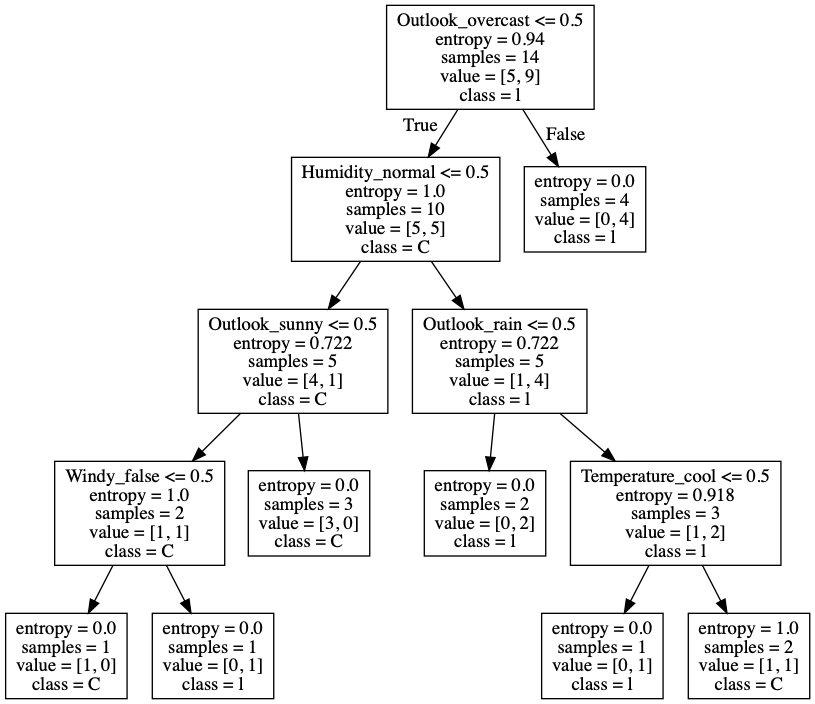

In [16]:
t = visualize_tree(clf, X_.columns, y.name)
Image(t)

For regression, you should use the `DecisionTreeRegressor` (again, refer to the [docs](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)).

## Feature importances

A great characteristic of decision trees is that they allow us to compute **feature importances**.

It is is given as the (normalized) decrease in node impurity, weighted by the proportion of samples reaching the node.

In [17]:
feature_importances = pd.Series(data=clf.feature_importances_, index=X_.columns)
feature_importances.sort_values(ascending=False)

Outlook_overcast    0.283411
Humidity_normal     0.249079
Windy_false         0.179147
Outlook_sunny       0.144181
Outlook_rain        0.076563
Temperature_cool    0.067618
Windy_true          0.000000
Humidity_high       0.000000
Temperature_mild    0.000000
Temperature_hot     0.000000
dtype: float64

Note, for example, that `Windy_true` has the most information gain. (Practice: do the math yourself.)

Nonetheless, once weighted by the proportion of sample reaching the node, this is not the most important feature.

## Pros and cons

### Pros

Decision trees are a straighforward way to represent rules that simply makes sense:

* Simple to understand, interpret and visualize
* Little to no data preparation
* Able to handle numerical and categorical variables
* White-box model, all decisions are replicable.

### Cons

Decision trees are extremely flexible and prone to create over-complex trees that don't generalize:
* Overfitting
* Overfitting
* Overfitting.

(Repetition makes perfect.)

Mechanisms such as pruning (removing sections of the tree) and setting the maximum depth of the tree help with overfitting.

In [18]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=2)
clf.fit(X_, y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=2,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

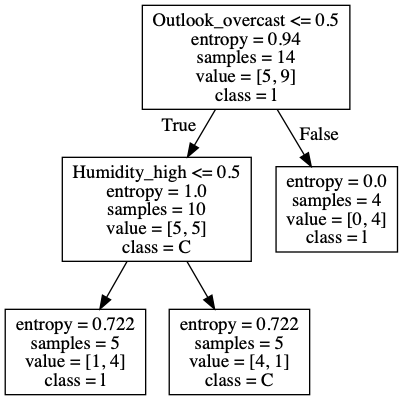

In [19]:
t = visualize_tree(clf, X_.columns, y.name)
Image(t)

We can also set the minimum number of samples required at a leaf node to avoid fully-grown trees.

In [20]:
clf = DecisionTreeClassifier(criterion='entropy', min_samples_split=5)
clf.fit(X_, y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

These all help with controlling overfitting, but they are simply not enough.

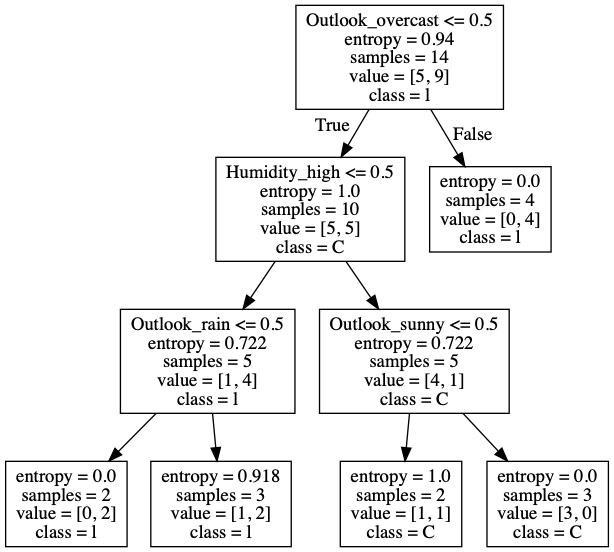

In [21]:
t = visualize_tree(clf, X_.columns, y.name)
Image(t)

If the attributes are adequate, it is always possible to construct a decision-tree that correctly classifies each training instance.

Attributes are **inadequate** if the data contains two objects that have identical values for each attribute and yet belong to different classes.

A key takeaway (repetition makes perfect): **decision trees overfit like hell**. In fact, they hallucinate.

## Tree-based ensembles

**Ensemble methods** combine the predictions of several models, known as **base learners** or **base estimators**.

<img src="assets/ensemble-methods.png" alt="ensemble-methods" style="width: 600px;"/>

*Fig. 3: A simple ensemble model, using many trained models to generate a single prediction.*

There are homogeneous and heterogenous ensembles, based on whether the base learners are all alike or not.

We focus on homogenous ensembles of decision-trees, particularly:

* Building several independent trees and then average their predictions, so that variance is reduced (i.e., **bagging**)
* Building trees sequentially as to reduce the bias of the combined estimator (i.e., **boosting**).

# Bagging with random forests

Bootstrap aggregating, also known as bagging, consists in:
1. Creating several independent data sets 
2. Training a model in each data set
3. Aggregating individual predictions.

Bagging can be seen as training several independent models in parallel and averaging the predictions.

Now, decision-trees don't simply overfit, as they are highly unstable: small variations in the data result in wildly different trees.

This makes them particularly suited for bagging.

## Bagging

Suppose you have a sequence of data sets $\{D_1, D_2, \dots, D_k\}$, with observations from the same underlying distribution $\mathcal{D}$.

We can obtain a **sequence of models**, $\{h_1, h_2, \dots, h_k\}$, by training a model in each data set.

<img src="assets/bagging-estimator.png" alt="bagging-estimator" style="width: 600px;"/>

*Fig. 4: In bagging different data sets are generated from the main one, models are trained in parallel and predictions averaged.*

By running the models in parallel, we get $\{\hat{y}_1\, \hat{y}_2\, \dots, \hat{y}_k\}$, a **sequence of predictions**.

To obtain a single prediction we can then evaluate all models and aggregate the results by:
* Averaging the $k$ predictions (regression)
* Using majority voting to predict a class (classification).

Most often than not, however, we don't have multiple data sets. Bootstapping is the answer.

## Bootstrapping

What we do, henceforth, is to take repeated random samples with replacement $\{C^1, C^2, \dots, C^b\}$ from $C$.

In [22]:
def make_bootstrap_data(data, b):
    n = data.shape[0]
    return [data.sample(n=n, replace=True) for i in range(b)]


bootstrap_data = make_bootstrap_data(data, 2)

Typycally, the bootstrap data sets are the same size as the original data set.

In [23]:
bootstrap_data[0]

,Outlook,Temperature,Humidity,Windy,Class
0,sunny,hot,high,false,0
10,sunny,mild,normal,true,1
4,rain,cool,normal,false,1
9,rain,mild,normal,false,1
9,rain,mild,normal,false,1
12,overcast,hot,normal,false,1
2,overcast,hot,high,false,1
7,sunny,mild,high,false,0
0,sunny,hot,high,false,0
10,sunny,mild,normal,true,1


In [24]:
bootstrap_data[1]

,Outlook,Temperature,Humidity,Windy,Class
3,rain,mild,high,false,1
6,overcast,cool,normal,false,1
0,sunny,hot,high,false,0
13,rain,mild,high,true,0
0,sunny,hot,high,false,0
12,overcast,hot,normal,false,1
5,rain,cool,normal,false,0
12,overcast,hot,normal,false,1
7,sunny,mild,high,false,0
0,sunny,hot,high,false,0


We would now train a different decision tree in each data set and use voting to predict whether to go hicking or not.

Bagging works surprisingly well in controlling overfitting and the generalization error in unstable models.

## Random forests

In **random forests**, bagging is used in tandem with random feature selection:
* Each training set is drawn, with replacement, from the original data (row sampling)
* Then a tree is grown on each bootstrap data set using random feature selection (column sampling).

Random feature selection means that only a random subset of the features is available at each split.

Randomizing features acts as a kind of regularization, further mitigating overfitting.

Fortunately, `sklearn` implements all this intricate logic implemented for us.

In [25]:
rf = RandomForestClassifier(n_estimators=10, criterion='entropy', max_features=2, bootstrap=True)
rf.fit(X_, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=2, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

For detailed information about the models, check the documentation:
* RandomForestClassifier ([docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html))
* RandomForstsRegressor ([docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)).

Bagging and, particularly, control overfitting at the cost of interpretability.

# Boosting with gradient boosting

**Boosting** consists of producing additive models sequentially, by fitting base learners to residuals. *What you saying?*

The gist is building strong ensembles by combining base learners sequentially, each correcting previous errors (thus reducing bias).

## Boosting

Trees are grown sequentially, as each tree is created using information derived from the previous tree. In each iteration:
1. Errors and misclassifications of the past model are given increased weight in a new training data set
2. The current model is trained on the new training set.

As such, each model specializes in correcting past mistakes and misclassifications. 

<img src="assets/boosting-estimator.png" alt="boosting-estimator" style="width: 600px;"/>

Intuitively, this produces an ensemble of models that are good in different "parts" of the training data.

In this example we will use the [boston](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html) house-prices data set (regression).

In [26]:
def prepare_boston():
    boston = load_boston()
    X = pd.DataFrame(data=boston.data, columns=boston.feature_names)
    y = pd.Series(data=boston.target, name='price')
    
    return X, y


X_boston, y_boston = prepare_boston()

## What do we mean by gradient

### A loss function

A loss function quantifies how bad our predictions are. An example is the squared error, below: 

$$L_i = (y_i - h(x_i))^2$$ 

We want to minimize the total loss, over all observations in the training set, with respect to the model $h(x)$: 

$$\min_{h(x)} J = \sum_{i=1}^N L(y_i, h(x_i))$$

In gradient boosting, we minimize the loss $L_i$ for each training instance $(x_i, y_i)$ in order to minimize the global error.

It allows to minimize any complex loss of our choosing, for as long as it is differentiable.

### And its slope at point $i$

The gradient stands for rate of inclination, or slope.

It's the fancy term for the multi-variable generalization of the derivative, i.e., the partial derivatives of function $f$ at point $i$.

In this particular case, by gradient we refer to the derivative of the loss $L$ with respect to the model $h(x_i)$, in the example above:

$$\frac{\partial L (y_i, h(x_i))}{\partial h(x_i)} = -2(y_i - h(x_i))$$

Now, for the gradient at a given point $i$, we plug-in the values of $y_i$ and $h(x_i)$.

### Also known as pseudo-residual

The **residual**, $r$, is the difference between the true value and the estimated value of a variable of interest.

For any **differentiable** loss function, the gradient is proportional to the residual, for example:

$$-2(y_i - h(x_i)) = -2(y_i - \hat{y_i}) = -2r_i$$

So the gradient is somewhat equivalent to the residual but specific to an arbitrary cost function.

The negative of the gradient is sometimes called the **pseudo-residual**.

## Gradient boosting

### Initialization

We initialize $h(x_i)$ to a sensible constant, $h^0(x_i) = \gamma$.

Since our goal is to minimize the squared error, we will use the mean value of the target variable in the training set.

In [27]:
y_boston_h0_pred = np.repeat(y_boston.mean(), y_boston.size)

We compute the mean squared error of this initial set of predictions.

In [28]:
mean_squared_error(y_boston, y_boston_h0_pred)

84.41955615616556

### Iterations

#### Generating a new data set

We build a new training set at the start of each iteration. Concretely, we recompute the target variable (all else remains the same).

So, at the $j$-th iteration we compute a new target variable $r^{(j)}_i$, corresponding to the gradient of the past iteration:

$$r^{(j)}_{i} = \frac{\partial L(y_i, h^{(j-1)}(x_i))}{\partial h^{(j-1)}(x_i)} = -2(y_i - h^{j - 1}(x_i))$$

Intuitively, it corresponds to the rate of change of the loss with respect to a small increase in the predicted value.

In [29]:
def compute_gradient(y, y_pred):
    return -2 * (y - y_pred)


y_boston_h0_residual = compute_gradient(y_boston, y_boston_h0_pred)

#### Training a decision-tree

Based on the new data set, we contruct a decision-tree that **predicts the gradient** $\hat{r}^{(j)}_i$, given $x_i$.

To be clear, we fit the decision-tree on the gradients.

In [30]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_boston, y_boston_h0_residual)


y_boston_h0_residual_pred = dt.predict(X_boston)

Typically, we will want to train the simplest, shallowest decision-trees as base learners.

(Hence, setting the maximum depth of the tree to one.)

#### Updating the predictions

The update rule goes as follows, where $\eta$ is a **learning rate** that controls the magnitude of the update:

$$h^{(j)}_{i}(x_i) = h^{(j - 1)}(x_i) - \eta \cdot \frac{\partial L(y_i, h^{(j-1)}(x_i))}{\partial h^{(j-1)}(x_i)}$$

The learning rate is also known as the *shrinkage factor*, as it shrinks the impact of the corrections if $\eta$ between 0 and 1.

Since we don't know the true value of $y_i$ at prediction time, we plug-in the prediction of the decision-tree:

$$h^{(j)}_{i}(x_i) \approx h^{(j - 1)}(x_i) - \eta \cdot \hat{r}^{(j)}_i(x_i) $$

Intuitively, we are following the (shrunken) slope, rolling down the hill towards minimizing the loss function.

In [31]:
def update_predictions(h0_preds, h0_residuals, lr):
    return h0_preds - lr * h0_residuals


y_boston_h1_pred = update_predictions(y_boston_h0_pred, y_boston_h0_residual_pred, lr=0.1)

(In many implementations, a learning rate $\eta_m$ is computed for each leaf. In this example, we use a static rate.)

Now, we compute the mean squared error for the updated predictions.

In [32]:
mean_squared_error(y_boston, y_boston_h1_pred)

70.66018894370501

Finally, we would continue the process until the error strops decreasing.

### All together now (and how to use it)

Suppose we have $m$ individual decision-trees, or, simply put, boosting stages.

The final prediction will be given by the sum of the initial constant and all the gradient-based corrections:

$$h^m_i(x_i) = \gamma + \sum_{j=1}^m \eta \cdot \hat{r}^{(j)}_i(x_i)$$

Where $\hat{r}^{(j)}_i(x_i)$ is the output of a decision-tree that predicts the gradient (which is a kind of residual) of the previous iteration.

Enough with theory: `sklearn` for the rescue.

In [33]:
gb = GradientBoostingClassifier(learning_rate=.1, n_estimators=10)
gb.fit(X_, y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=10,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

#### Include sampling (if you fell like it)

Some implementations provide the ability to sample observations and features at each iteration, *à la* Random Forests.

Unsurprisingly, this reduces overfitting at the expense of increased bias.

In [34]:
gb = GradientBoostingClassifier(learning_rate=.1, n_estimators=10, subsample=.5)
gb.fit(X_, y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=10,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=0.5, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In the case above, `sklearn` gives us the ability to subsample individual observations (i.e., rows).